# Task 3 and 4: Multilayer Perceptron
---

---

# Explore XAI techniques on the Student’s Dropout Dataset

**Course:** Advanced Topics in Machine Learning

**Group:** DS2-G3
        
    Alexandre Sousa: 202206427
    Magda Costa: 202207036
    Rafael Pacheco: 202206258

---

---

# Index  <a name = "index"></a>

1. [Data Preprocessing](#preprocess)
2. [Full Neural Network Pipeline](#pipeline)
3. [MLP](mlp)
    - [Post-Hoc Explainability Techniques: Simplification Based](#mlp_sb)
        - [Decision Tree Surrogate](#mlp_sb_dt)
    - [Post-Hoc Explainability Techniques: Feature Based](#mlp_fb)
        - [SHAP Values (KernelShap)](#mlp_shap)
        - [Local SHAP - Two Examples](#mlp_shap_2)
        - [Permutation Feature Importance](#mlp_pfi)
        - [Local LIME - Two Examples](#mlp_lime_2)
    - [Post-Hoc Explainability Techniques: Example Based](mlp_eb)
        - [Anchors](#mlp_anchors_2)
    - [Faithfulness Rank Correlationt to compare Pos-Hoc methods](#frc)

---

---

In [ ]:
# Main Frameworks
import pandas as pd
import numpy as np
import warnings
import random

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score, roc_auc_score


# Saving the Model
import pickle
from pathlib import Path

---

---

## Data Preprocessing <a name = "preprocess"></a>
[[go back to Index]](#index)

In [2]:
N_FEATURES_XAI = 18 # manually adjusted for visual appeal in plots

In [3]:
df = pd.read_csv("data_preprocessed.csv", sep=",")
df.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


---

## Full Neural Network Pipeline <a name = "pipeline"></a>
[[go back to Index]](#index)

### Data Preparation

All of the steps below follow the same rules as XGBoost, for comparison purposes.

In [ ]:
X = df.drop(columns=["Target"]).values.astype(np.float32)
y = df["Target"].values.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Creating the `PyTorch` Dataset Object

Here, we define the Dataset object (pytorch requires data loaders):

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# MLP <a name = "mlp"></a>
[[go back to Index]](#index)

### Model Setup

We'll be using a simple, Multi Layer Perceptron (MLP) model as a baseline (cuda enabled):

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

Using device: cuda


### Training and Testing

#### Training Loop

To train the model, simply change the cell to `python`:

---

```py
model = MLP(input_dim=X.shape[1], num_classes=len(np.unique(y))).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 180

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


---

#### Saving the Model

We'll use `pkl` instead of `torch.save` to avoid common pitfalls and accidental overwrites:

In [8]:
# Function to name files without overwrites
def avoidOverwrite(base_path):
    base = Path(base_path)
    if not base.exists(): return base

    i = 1
    while True:
        new_path = base.with_stem(f"{base.stem}_{i}")
        if not new_path.exists(): return new_path
        i += 1

save_path = avoidOverwrite("pickle_jar/mlp_model.pkl")

---

```py
collection = {
    "model_state_dict": model.state_dict(),
    "input_dim": X.shape[1],
    "num_classes": len(np.unique(y)),
}

with open(save_path, "wb") as f:
    pickle.dump(collection, f)

print(f"Model saved to: {save_path}")

---

To load these models:

In [9]:
with open("pickle_jar/mlp_model.pkl", "rb") as f:
    artifact = pickle.load(f)

model = MLP(
    artifact["input_dim"],
    artifact["num_classes"]
).to(device)

model.load_state_dict(artifact["model_state_dict"])
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

Structure integrity check:

In [ ]:
summary(model, input_size=(64, X.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Linear: 2-1                       [64, 64]                  2,368
│    └─ReLU: 2-2                         [64, 64]                  --
│    └─Linear: 2-3                       [64, 32]                  2,080
│    └─ReLU: 2-4                         [64, 32]                  --
│    └─Linear: 2-5                       [64, 2]                   66
Total params: 4,514
Trainable params: 4,514
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.29
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.02
Estimated Total Size (MB): 0.08

---

### Model Evaluation

We use simple accuracy and confusion matrix metrics:

In [87]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_true.extend(yb.numpy())
        y_pred.extend(preds)

#### Performance Assessment

In [88]:
class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def fit(self, X, y): return self # (required although model is already trained)

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            logits = self.model(X_tensor)
            return torch.argmax(logits, dim=1).cpu().numpy()
        
    # Exposes prediction probabilities
    def predict_proba(self, X):
        # convert to NumPy if it's a DataFrame
        if hasattr(X, "values"): X = X.values
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

In [89]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

y_prob = PyTorchWrapper(model, device).predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_true, y_prob)  

print(f"Accuracy: {acc}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n")

cm_df = pd.DataFrame(cm,
    index=[f"True_{i}" for i in range(cm.shape[0])],
    columns=[f"Pred_{i}" for i in range(cm.shape[0])])
print(cm_df,"\n\n")

print(classification_report(y_true, y_pred, digits=3))

Accuracy: 0.9008264462809917
F1 Score: 0.9205298013245033
ROC-AUC: 0.9399018545663119
Confusion Matrix:

        Pred_0  Pred_1
True_0     237      47
True_1      25     417 


              precision    recall  f1-score   support

           0      0.905     0.835     0.868       284
           1      0.899     0.943     0.921       442

    accuracy                          0.901       726
   macro avg      0.902     0.889     0.894       726
weighted avg      0.901     0.901     0.900       726



We instantly achieve amazing results, but get **no insights regarding the decision making process**, nor the type of patterns or conditions learnt.

---

## Post-Hoc Explainability Techniques: Simplification Based <a name = "mlp_sb"></a>
[[go back to MLP]](#mlp)

Although MLP's aren't extremely complex when compared to common deep learning algorithms, they can still be extrememly difficult to comprehend.

Using a surrogate model can provide transparency to an otherwise opaque technique. For this reason, we decided to train a decision tree with the goal of understanding our neural network's decision process.

To do so, we carried out the following procedure:

1. Train a Neural Network (MLP) on a training data split
2. Test the MLP on test data split
3. Create predictions for training data, using MLP
4. Create predictions for test data, using MLP
5. Train a Decision Tree on the MLP's predictions of training data
   1. The DT then creates rules based on patterns identified by the MLP as relevant to the task at hand
6. Test the DT on the MLP's predictions for the test data
   1. The DT can be tested for how well it follows the MLP's decision process, even with simpler rules


### Decision Tree Surrogate <a name = "mlp_sb_dt"></a>
[[go back to MLP]](#mlp)

In [90]:
# Decision Tree Surrogate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [91]:
# We already have class predictions, but this gives us quick probabilities 
def nn_predict(X):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad(): return torch.argmax(model(X), dim=1).cpu().numpy()

Now, we'll fit the decision tree's rule-making process by using predictions made by the MLP. This will approximate the MLP's patterns as simple rules:

In [92]:
nn_train_preds = nn_predict(X_train)
nn_test_preds  = nn_predict(X_test)

dt_surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_surrogate.fit(X_train, nn_train_preds)

dt_surrogate_preds = dt_surrogate.predict(X_test)
fidelity = accuracy_score(nn_test_preds, dt_surrogate_preds)

print(f"Decision Tree fidelity to NN behavior: {fidelity:.4f}")

Decision Tree fidelity to NN behavior: 0.9036


This result ensures that the decision tree captures the neural network's decision process almost perfectly. Let's analyze it:

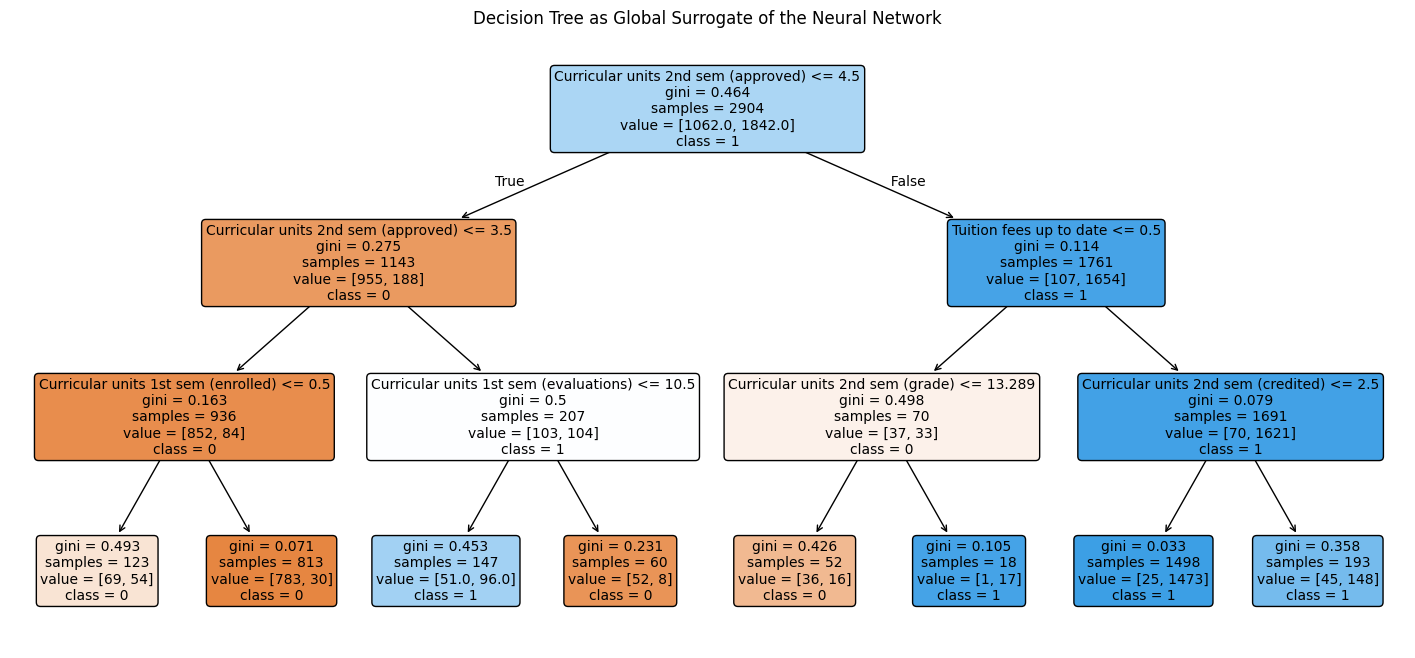

In [93]:
plt.figure(figsize=(18, 8))
plot_tree(
    dt_surrogate,
    feature_names=df.drop(columns=["Target"]).columns,
    class_names=[str(c) for c in sorted(df["Target"].unique())],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree as Global Surrogate of the Neural Network")
plt.show()

It's important to take into consideration that the values where the DT decides to split are continuous due to decision between integer values. The actual instances are (as mentioned in the first notebook, [task_1_1_all_data_analysis.ipynb](task_1_1_all_data_analysis.ipynb)) mostly integers.

Let's carry out a structure and rule analysis:

1. **`Root split`**

     - **Curricular units approved in the 2nd semester** is the root node: This implies it is the **most informative** feature globally.
  
2. **`Key decision paths`**
     - **Low 2nd-semester approvals $\rightarrow$ High probability of non-graduation**: Further splits on enrollment and performance rarely contradict the negative prediction
     - **High 2nd-semester approvals + tuition fees up to date $\rightarrow$ High probability of graduation**: Financial security and stability further leads to positive effect in academic success
     - **Intermediate approval levels**: Previous qualifications and enrollment load also affect outcomes

---

## Post-Hoc Explainability Techniques: Feature Based <a name = "mlp_fb"></a>
[[go back to MLP]](#mlp)

### SHAP Values (KernelShap) <a name = "mlp_shap"></a>
[[go back to MLP]](#mlp)

In [94]:
import shap

In [95]:
def model_forward(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_tensor)
        return logits[:, 1].cpu().numpy()  

In [96]:
# Uses train entries
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer_s = shap.KernelExplainer(model_forward, background)

# Uses all test entries (global explanation)
X_explain = X_test
shap_values = explainer_s.shap_values(X_explain)

feature_names=df.drop(columns=["Target"]).columns
top_feature_names = feature_names[N_FEATURES_XAI:]

# Map names → indices
feature_idx_map = {name: i for i, name in enumerate(feature_names)}
top_feature_indices = [feature_idx_map[f] for f in top_feature_names]

X_top = X_explain[:, top_feature_indices]
shap_top = shap_values[:, top_feature_indices]

  0%|          | 0/726 [00:00<?, ?it/s]

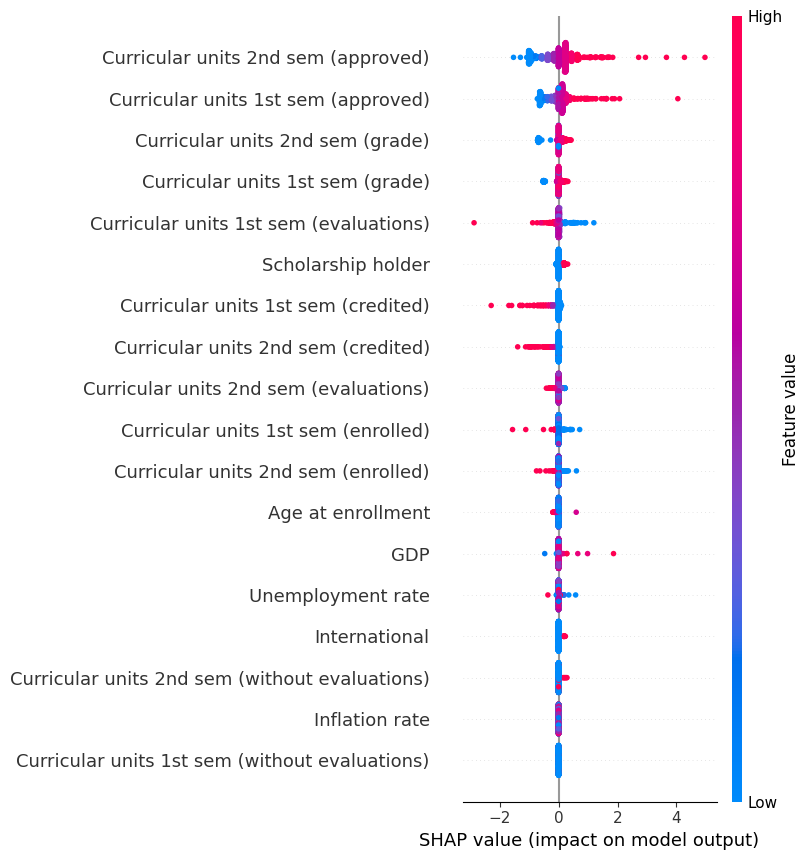

In [97]:
shap.summary_plot(
    shap_top,
    X_top,
    feature_names=top_feature_names
)

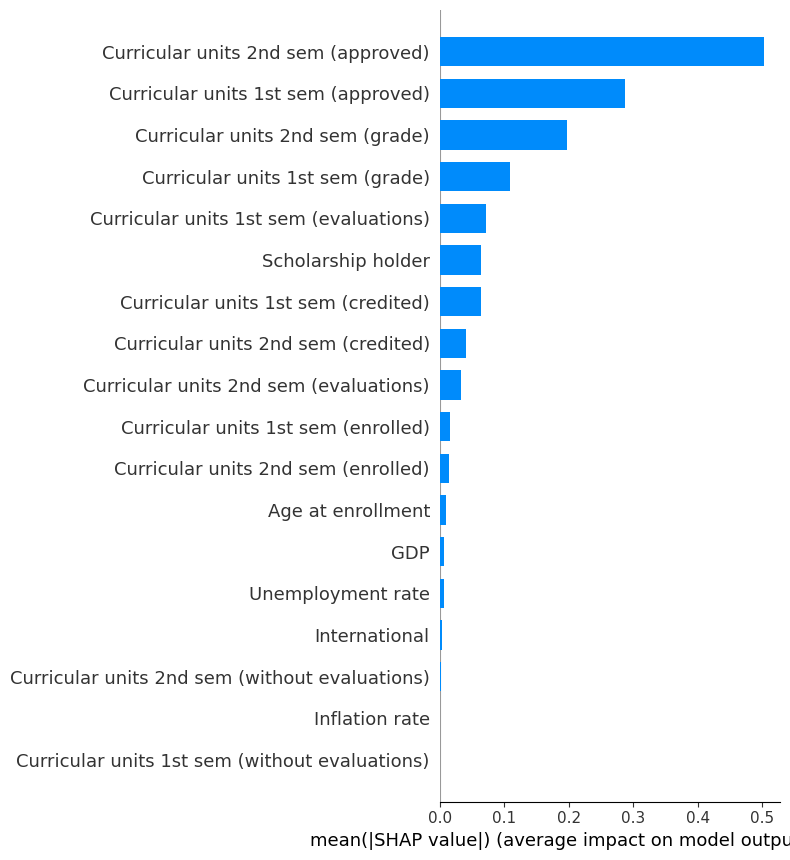

In [98]:
shap.summary_plot(
    shap_top,
    X_top,
    feature_names=top_feature_names,
    plot_type="bar",
    show=False
)

The SHAP beeswarm plot indicates that, once again, the model is highly guided by academic performance indicators. 


Most notably, we can identify a **strong direct proportion between high feature values and impact**, when considering:
 - Curricular Units (2nd sem, approved)
 - Curricular Units (1st sem, approved)
 - Curricular Units (2nd sem, grade)
 - Curricular Units (1st sem, grade)

When comparing to results in XGBoost, the NN prioritizes approval and grades above Tuition Fees.

With less incidence in cases like:
 - Scholarship Holder
 - International

We can also identify **intense direct proportion of low feature values and high impact**, more specifically in:
 - Curricular Units (1st sem, credited)
 - Curricular Units (2nd sem, credited)

Many of the features show **arbitrary and unidentifiable division of correlations**.

These values indicate that **grades** and **approval** in curricular units are **highly important** for the model's decision making, but other factors like **nationality**, **scholarship** and **GDP** might still affect overall classification (with some degree of **identifiability of effect**).


### Local SHAP - Two Examples <a name = "mlp_shap_2"></a>
[[go back to MLP]](#mlp)

Moving on to local examples:

In [99]:
# Getting index for guaranteed example in both classes
idx_class0 = np.where(np.array(y_true) == 0)[0]
idx_class1 = np.where(np.array(y_true) == 1)[0]


# Random and reproducible
# rng = np.random.default_rng(42) 
# random0, random1 = random.choice(idx_class0), random.choice(idx_class1)  

# Using the same instances as XGBoost
random0, random1 = idx_class0[0], idx_class1[0]  

In [100]:
X_two = np.vstack([
    X_test[idx_class0][0],
    X_test[idx_class1][0]
])

shap_values_two = explainer_s(X_two)

  0%|          | 0/2 [00:00<?, ?it/s]

For the type of plots below:

 - Blue indicates features that pull classification toward the lowest value output (Dropout == 0)
 - Red pulls classification toward the highest output value (Graduate == 1)


SHAP local explanation for instance 0, true class = 0


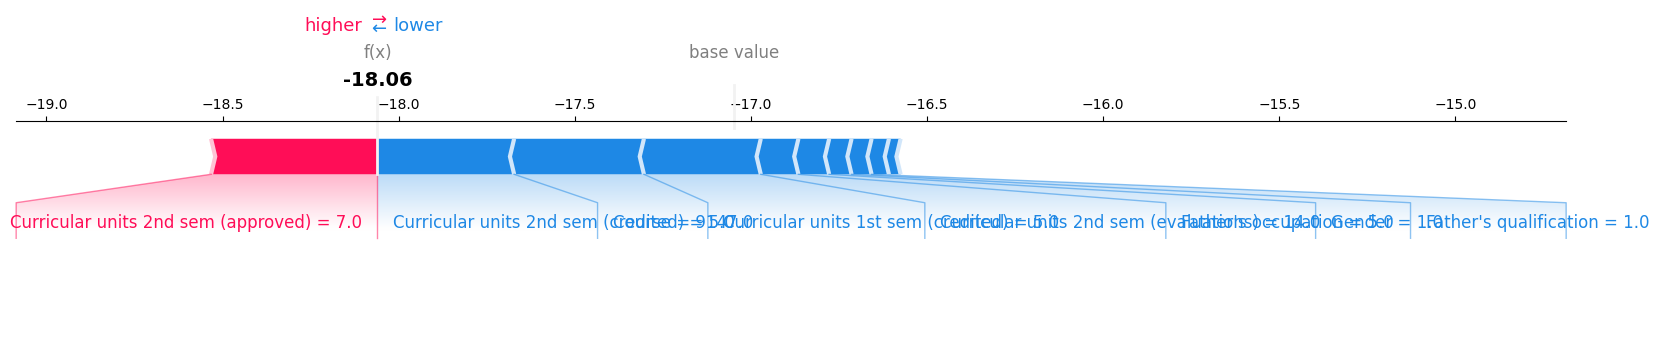

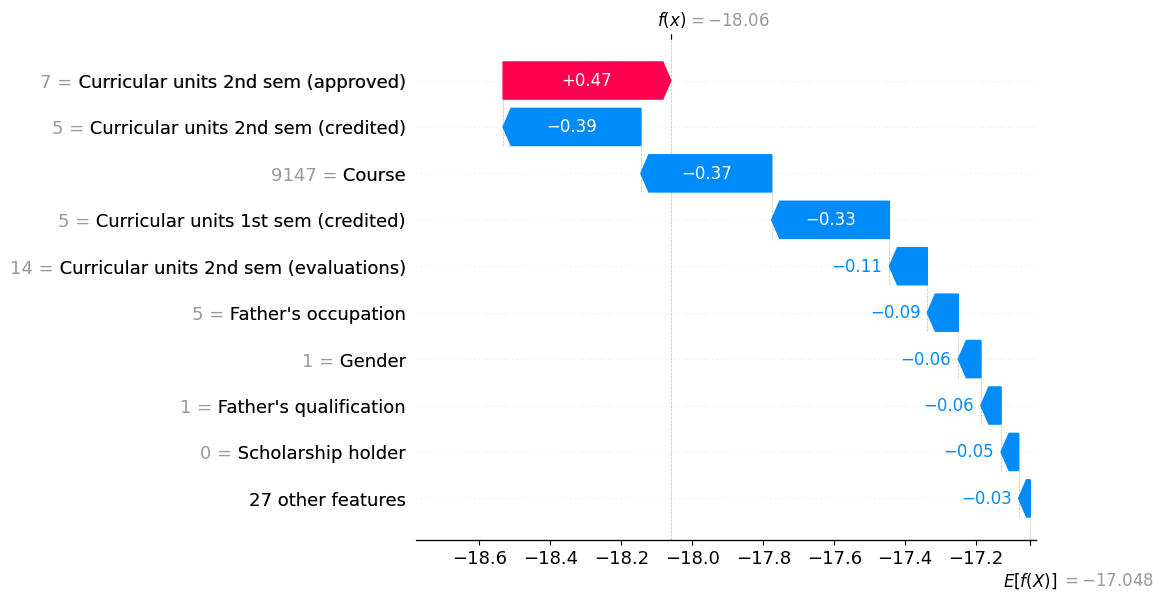

In [101]:
X_two_df = pd.DataFrame(X_two, columns=feature_names)


# force plot interactivo (notebook / html)
for i, idx in enumerate([idx_class0[0]]):
    print(f"\nSHAP local explanation for instance {idx}, true class = {y_test[idx]}")
    shap.force_plot(
        explainer_s.expected_value,
        shap_values_two.values[i],
        X_two_df.iloc[i, :],
        matplotlib=True  # gráfico estático
    )

# waterfall plot
for i, idx in enumerate([idx_class0[0]]):
    expl = shap.Explanation(
        values=shap_values_two[i],
        base_values=explainer_s.expected_value,
        data=X_two_df.iloc[i, :],
        feature_names=feature_names
    )
    
    shap.plots.waterfall(
        expl,
        max_display=10,
        show=True
    )


For this correctly classified specific <span style="color:blue"> Dropout </span> example:
1. The relatively decent number of approved curricular units in the second semester, paired with relatively high admission grade, pull the model towards the Graduate classification
2. However, the specific combination of low credited units (both in 1st and 2nd semester) and evaluation (2nd semester) with the course overcome the previous information, ultimately classifying this example as Dropout
   1. It's worth mentioning that the father's qualification and occupation (as well as the individual's gender) still somewhat contribute to the Dropout conclusion


SHAP local explanation for instance 1, true class = 1


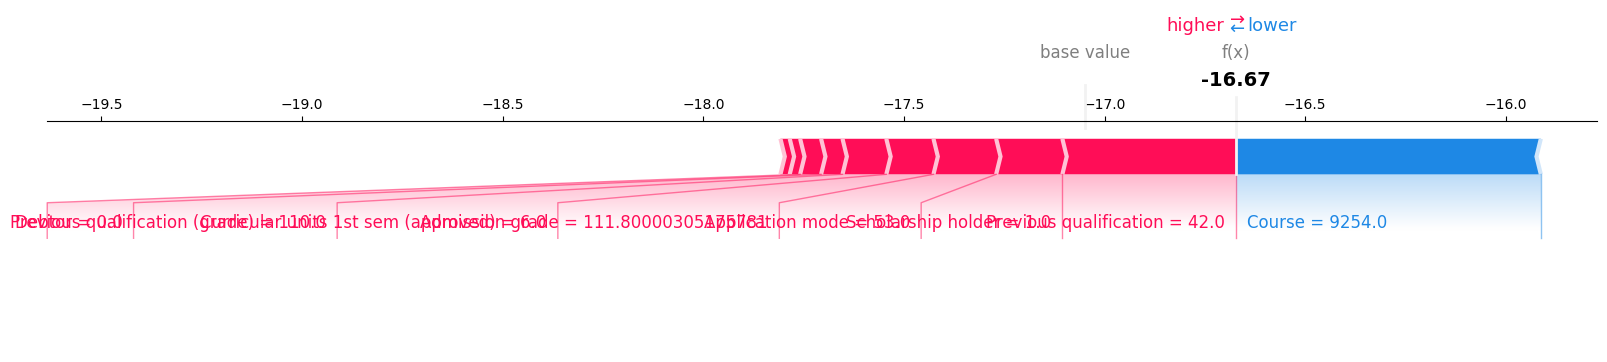

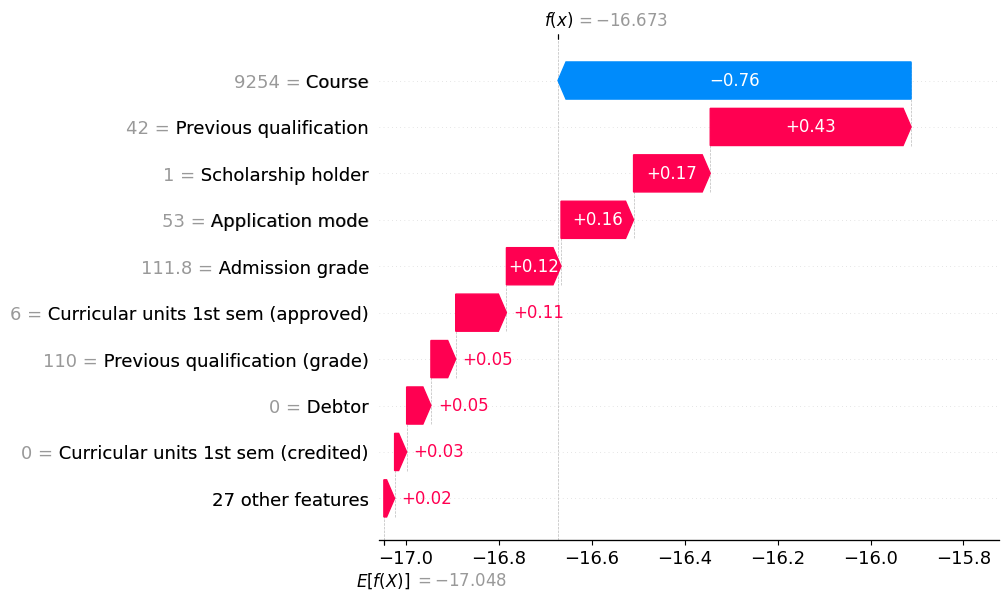

In [102]:
# force plot interactivo (notebook / html)
for i, idx in enumerate([idx_class1[0]]):
    print(f"\nSHAP local explanation for instance {idx}, true class = {y_test[idx]}")
    shap.force_plot(
        explainer_s.expected_value,
        shap_values_two.values[1],
        X_two_df.iloc[1, :],
        matplotlib=True  # gráfico estático
    )

# waterfall plot
for i, idx in enumerate([idx_class1[0]]):
    expl = shap.Explanation(
        values=shap_values_two[1],
        base_values=explainer_s.expected_value,
        data=X_two_df.iloc[1, :],
        feature_names=feature_names
    )
    
    shap.plots.waterfall(
        expl,
        max_display=10,
        show=True
    )


For this correctly classified specific <span style="color:red"> Graduate </span> example:

1. The course identifier strongly leads the model to classify as Dropout
2. However, the specific combination of the student's previous qualification and high admission grade, with being a scholar and having a high number of 1st semester approved units, ultimately guides the model to classify as Graduate
   1. It's worth mentioning that previous qualification's grade and no debts still somewhat contribute to the Graduate conclusion

---

### Permutation Feature Importance (PFI) <a name = "mlp_pfi"></a>
[[go back to MLP]](#mlp)

In [103]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, make_scorer

`PyTorch` needs the previously created wrapper for PFI:

In [104]:
# Wrap accuracy_score as a scorer
acc_scorer = make_scorer(accuracy_score)

# Use the same wrapper from before
wrapper = PyTorchWrapper(model, device)

perm = permutation_importance(
    estimator=wrapper,
    X=X_test,
    y=y_true,
    n_repeats=10,
    random_state=42,
    scoring=acc_scorer)

feature_names = df.drop(columns=["Target"]).columns
importances = perm.importances_mean

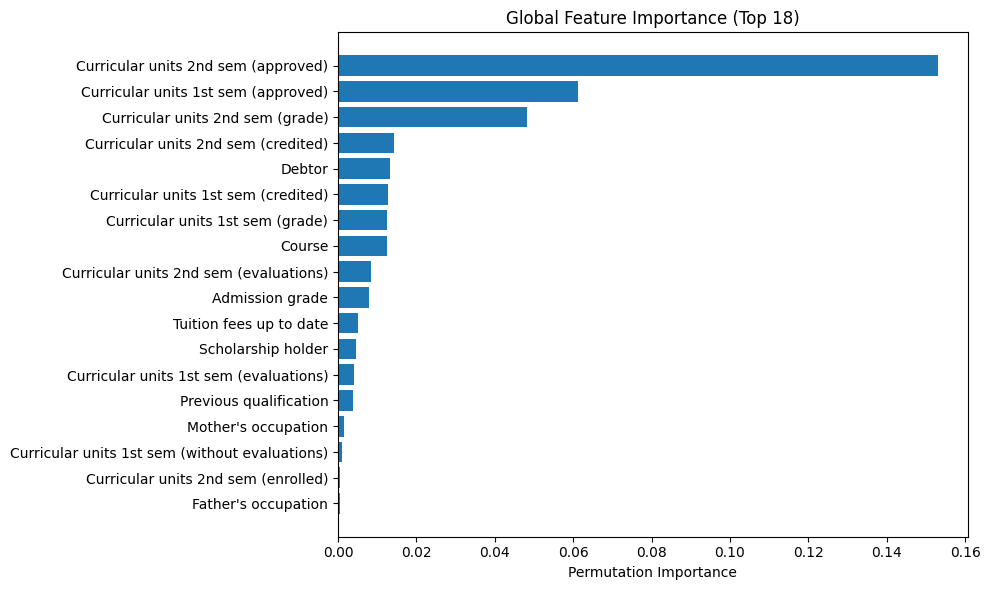

In [105]:
# Sort features by importance
sorted_idx = np.argsort(importances)
top_idx = sorted_idx[-N_FEATURES_XAI:]

sorted_features = feature_names[top_idx]
sorted_importances = importances[top_idx]

# Plot
plt.figure(figsize=(10,6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Permutation Importance")
plt.title("Global Feature Importance (Top 18)")
plt.tight_layout()
plt.show()

This PFI plot confirms all previous SHAP conclusions, by placing Curricular Unit approval and grade on the top of the importance hierarchy. Interestingly, PFI also places importance in some sensitive features, such as `Debtor` and `Tuition fees up to date`, which could potentially be indicative of a certain level of bias in financial interest during the model's decision process.

When compared to XGBoost, the hierarchy is quite similar.

---

### Local LIME - Two Examples <a name = "mlp_lime_2"></a>
[[go back to MLP]](#mlp)

Once again, we use the same examples for comparability purposes.

In [106]:
from lime.lime_tabular import LimeTabularExplainer

Small adaptation for correct LIME value input (avoids data type conflicts):

In [107]:
feature_names = df.drop(columns=["Target"]).columns.tolist()

def predict_fn(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

In [108]:
# Use training data for background distribution
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=["Dropout == 0", "Graduate == 1"], 
    mode="classification")

Sanity check:

In [109]:
i0 = random0  # index you used
print("y_true[idx]         :", y_true[i0])
print("y_pred[idx]         :", y_pred[i0])
print("model probs on X_test[idx]:", predict_fn(X_test[i0].reshape(1, -1)))

y_true[idx]         : 0
y_pred[idx]         : 0
model probs on X_test[idx]: [[0.8195996  0.18040033]]


For the type of plots below:

 - Green indicates features that pull classification toward the class in the title
 - Red pulls classification away from the identifier in the title

Showing LIME for instance  0 of Class 0!



<Figure size 1000x600 with 0 Axes>

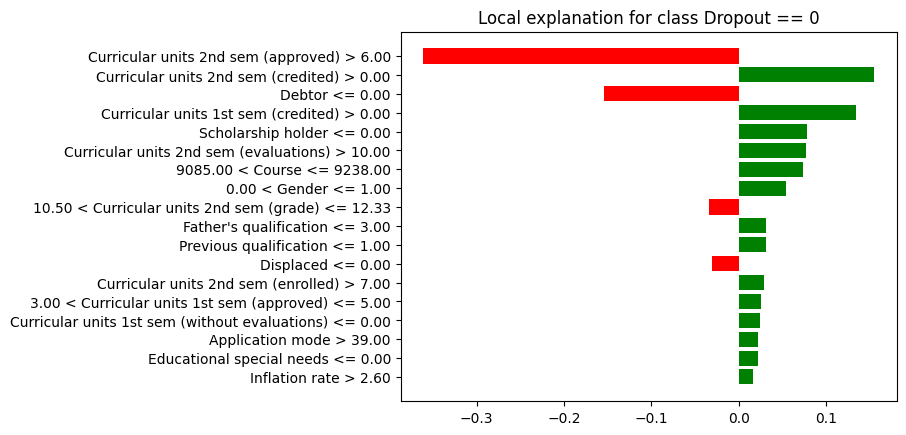

In [110]:
#i = random.choice(range(0,200))
warnings.filterwarnings("ignore") # avoids cluttered graph text

# Class 0
print("Showing LIME for instance ", 0,"of Class 0!\n")

# Contains all {feature:importance} pairs
exp = explainer.explain_instance(
    data_row=X_test[random0],
    predict_fn=predict_fn,
    labels=[0],
    num_features=N_FEATURES_XAI)

# Defining size helps with comprehension
plt.figure(figsize=(10, 6))
plt.tight_layout()
fig = exp.as_pyplot_figure(label=0)
fig.show()


For this correctly classified specific Dropout example:
1. The relatively decent number of approved curricular units in the second semester, paired with absence of debt, pull the model towards the Graduate classification
2. However, the specific combination of credited units (both in 1st and 2nd semester) and lack of scholarship with the course identifier eventually overcome the previous information, ultimately classifying this example as Dropout
   1. It's worth mentioning that the father's qualification still somewhat contributes to the Dropout conclusion

Showing LIME for instance  0 of Class 1!



<Figure size 1000x600 with 0 Axes>

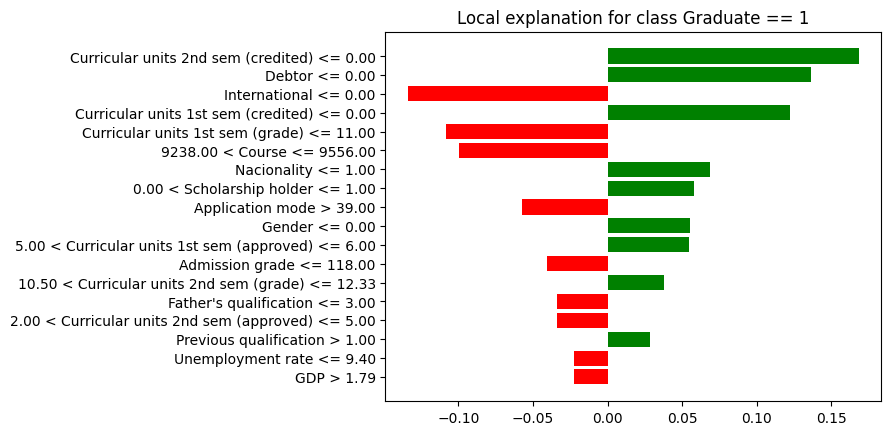

In [111]:
# Class 1
print("Showing LIME for instance ", 0,"of Class 1!\n")

exp = explainer.explain_instance(
    data_row=X_test[random1],
    predict_fn=predict_fn,
    num_features=N_FEATURES_XAI )
plt.figure(figsize=(10, 6))
plt.tight_layout()
fig = exp.as_pyplot_figure()
fig.show()

For this correctly classified specific Graduate example:
1. There are multiple features which contribute negativelly to this classification, pulling the model towards the Dropout conclusion:
   1. The most notable are the low international value, low 1st semester grades and specific course
2. However, the specific combination of absence of credited units (1st and 2nd semester) and lack of debt with the nationality and scholarship eventually overcome the previous information, ultimately classifying this example as Graduate
   1. It's worth mentioning that the individual's gender still somewhat contributes to the Dropout conclusion


These conclusions are strongly supported by the results above, and indicate that **academic progress**, **financial stability and support** and **nationality** are key elements, which **greatly impact graduation likelyhood**.

---

## Post-Hoc Explainability Techniques: Example Based <a name = "mlp_eb"></a>
[[go back to MLP]](#mlp)

### Anchors <a name = "mlp_anchors_2"></a>
[[go back to MLP]](#mlp)

*“If these feature conditions hold, the model is very likely to predict this class.”*

To do this, the algorithm generates neighbouring instances of the original student, keeping some features fixed (those in the rule) and perturbing the remaining ones with value taken from other students. It then performs a greedy search for rule with **high precision** (the percentage of neighbours with the same prediction) and computes de **coverage** (the percentage of examples in the dataset where the rule apllies).

Rules with higher coverage describe more general situations, while very specific rules with low coverage usually appear near the decision boundary, where the model is more sensitive to small changes in the features.

In [114]:
from alibi.explainers import AnchorTabular

In [115]:
def anchor_display(explainer_anchor, random0):
    # Explain a single instance
    exp_anchor = explainer_anchor.explain(X_test[random0])

    print("Anchor rules:")
    for rule in exp_anchor.anchor: print("   |",rule)
    print(f"Precision: {exp_anchor.precision:.2f}, Coverage: {exp_anchor.coverage:.2f}")

    pred0 = y_pred[random0]

    print("Prediction:", pred0)
    print("True label:", y_test[random0])

    return exp_anchor, pred0

In [116]:
explainer_anchor = AnchorTabular(predictor=wrapper.predict,feature_names=feature_names)
explainer_anchor.fit(X_train)

exp_anchor0, pred0 = anchor_display(explainer_anchor, random0)
print("\n","-----"*10,"\n")
exp_anchor1, pred1 = anchor_display(explainer_anchor, random1)

Anchor rules:
   | Curricular units 2nd sem (grade) <= 12.33
   | Curricular units 1st sem (approved) <= 5.00
   | Curricular units 2nd sem (enrolled) > 6.00
   | Previous qualification (grade) > 125.00
Precision: 0.97, Coverage: 0.03
Prediction: 0
True label: 0

 -------------------------------------------------- 

Anchor rules:
   | Curricular units 2nd sem (approved) > 2.00
   | Scholarship holder > 0.00
   | Curricular units 1st sem (approved) > 5.00
Precision: 0.97, Coverage: 0.18
Prediction: 1
True label: 1


 - **For student A:**
  This anchor rule shows very high precision (0.97) with low coverage (0.03). It indicates that in a small and fairly specific region of the feature space (relatively low grades in the 2nd semester, few approved curricular units in the 1st semester, a high number of enrolled units in the 2nd semester, and a relatively high previous qualification grade) the model almost always predicts Dropout. In this case, that prediction matches the true label. The limited coverage means that only a small subset of students satisfy these conditions, but within this interval the model behaves very consistently and reliably.
 - **For student B:**
  For this case, the precision remains equally high (0.97), but the coverage is substantially larger (0.18), meaning that this rule applies to around 18% of the dataset. The rule captures students who have more approved curricular units in both semesters and are scholarship holders. In this larger region of the feature space, the model strongly predicts Graduate, and for this particular student the prediction is correct. This suggests that the model has learned a robust and more general pattern, capable of linking academic progression and financial support to a positive outcome.

These two examples illustrate how Anchors can highlight highly specific model behaviours (like the Dropout example) but also more general patterns that apply to a larger ammount of students (Graduate example) in a structured, comprehensible output.


In [ ]:
rng = np.random.RandomState(0)

results = []
max_per_class = 200

predict_fn = lambda x: wrapper.predict(np.array(x))

for class_label in [0, 1]:
    class_indices = np.where(y_test == class_label)[0]
    n_sample = min(max_per_class, len(class_indices))
    chosen = rng.choice(class_indices, size=n_sample, replace=False)

    for i in chosen:
        instance = X_test[i]
        exp = explainer_anchor.explain(instance, threshold=0.95)
        rule = " AND ".join(exp.anchor) if exp.anchor else "(no anchor found)"
        pred = predict_fn([instance])[0]

        row = {
            "idx": int(i),
            "class": int(class_label),
            "anchor": rule,
            "precision": exp.precision,
            "coverage": exp.coverage,
            "prediction": int(pred),
        }

        true_label = y_test[i]
        row["true_label"] = int(true_label)
        row["correct"] = int(true_label == pred)

        results.append(row)

anchors_df = pd.DataFrame(results)

summary_df = (
    anchors_df
    .groupby(["class", "anchor"])
    .agg(
        n_instances=("idx", "count"),
        mean_precision=("precision", "mean"),
        mean_coverage=("coverage", "mean"),
        mean_correct=("correct", "mean"),
    )
    .sort_values(["class", "n_instances"], ascending=[True, False])
)

for class_label in [0, 1]:
    print(f"Top 10 anchors for class {class_label}:")
    class_rules = summary_df.loc[class_label]
    display(class_rules.head(10))

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.
Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Top 10 anchors for class 0:


,n_instances,mean_precision,mean_coverage,mean_correct
anchor,,,,
Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (evaluations) > 10.00,19,0.982116,0.055089,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Debtor > 0.00,18,0.978374,0.056278,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (approved) <= 3.00,8,0.957165,0.249938,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 2nd sem (evaluations) > 10.00,8,0.975997,0.043913,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Age at enrollment > 26.00,7,0.962898,0.105057,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Age at enrollment > 20.00 AND Curricular units 1st sem (approved) <= 3.00,4,0.991296,0.154950,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Application mode > 39.00,4,0.962467,0.034550,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (approved) <= 3.00 AND Curricular units 2nd sem (enrolled) > 5.00,4,1.000000,0.106450,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (evaluations) > 8.00,4,0.962254,0.089575,1.0


Top 10 anchors for class 1:


,n_instances,mean_precision,mean_coverage,mean_correct
anchor,,,,
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 13.50,35,0.964540,0.180674,1.0
Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 13.50,29,0.977200,0.097769,1.0
Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 12.33,20,0.964335,0.169880,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 12.33 AND Curricular units 1st sem (evaluations) <= 8.00,7,0.993221,0.253014,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 12.33 AND Age at enrollment <= 19.00,6,0.992635,0.207250,1.0
Curricular units 2nd sem (approved) > 5.00 AND Scholarship holder > 0.00 AND Curricular units 1st sem (approved) > 5.00,6,0.985525,0.162433,1.0
Curricular units 2nd sem (approved) > 2.00 AND Curricular units 2nd sem (grade) > 13.50 AND Age at enrollment <= 19.00,5,0.995258,0.140820,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 1st sem (approved) > 5.00 AND Curricular units 1st sem (credited) <= 0.00,5,0.994027,0.330120,1.0
Curricular units 2nd sem (approved) > 2.00 AND Curricular units 2nd sem (grade) > 12.33 AND Curricular units 1st sem (evaluations) <= 8.00,4,0.983960,0.347150,1.0


In [ ]:
# compact table
_top5 = (
    summary_df.reset_index()
    .sort_values(["class", "n_instances"], ascending=[True, False])
    .groupby("class", group_keys=False)
    .head(5)
    .assign(rank=lambda df: df.groupby("class").cumcount() + 1)
    .set_index(["class", "rank"])
    [["anchor", "n_instances", "mean_precision", "mean_coverage", "mean_correct"]]
)

with pd.option_context("display.max_colwidth", None):
    display(_top5)

anchor  \
class rank                                                                                                                                               
0     1                                                 Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (evaluations) > 10.00   
      2                                                                                  Curricular units 2nd sem (approved) <= 2.00 AND Debtor > 0.00   
      3                                                    Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 1st sem (approved) <= 3.00   
      4                                                 Curricular units 2nd sem (approved) <= 2.00 AND Curricular units 2nd sem (evaluations) > 10.00   
      5                                                                      Curricular units 2nd sem (approved) <= 2.00 AND Age at enrollment > 26.00   
1     1                                                        Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 13.50   
      2                                                        Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 13.50   
      3                                                        Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 12.33   
      4     Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 12.33 AND Curricular units 1st sem (evaluations) <= 8.00   
      5                         Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 12.33 AND Age at enrollment <= 19.00   

            n_instances  mean_precision  mean_coverage  mean_correct  
class rank                                                            
0     1              19        0.982116       0.055089           1.0  
      2              18        0.978374       0.056278           1.0  
      3               8        0.957165       0.249938           1.0  
      4               8        0.975997       0.043913           1.0  
      5               7        0.962898       0.105057           1.0  
1     1              35        0.964540       0.180674           1.0  
      2              29        0.977200       0.097769           1.0  
      3              20        0.964335       0.169880           1.0  
      4               7        0.993221       0.253014           1.0  
      5               6        0.992635       0.207250           1.0

The MLP and XGBoost anchors tell essentially the same story: both models base their decisions mainly on second-semester academic performance, with few approved units anchoring dropout and many approved units with high grades anchoring graduation. The MLP anchors add slightly more nuanced conditions (age, admission grade, debtor status), but they reinforce rather than change the core patterns found with XGBoost.

---

## Faithfulness Rank Correlation in Pos-Hoc Methods <a name = "frc"></a>
[[go back to MLP]](#mlp)

Here, we use PFI as the anchor for faithfulness, in order to identify what the model truly relies on for predictions.

In [117]:
from scipy.stats import spearmanr
from IPython.display import display, HTML

In [118]:
feature_names = [f for f in feature_names if f != "Target"]

assert X_train.shape[1] == len(feature_names), (
    f"X has {X_train.shape[1]} features, "
    f"but feature_names has {len(feature_names)}")

# Wrap the trained PyTorch model
wrapped_model = PyTorchWrapper(model, device)

# ---------------------------------------------------------
# 1. Permutation Feature Importance (PFI) — reference
# ---------------------------------------------------------
pfi_result = permutation_importance(
    wrapped_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=0,
    n_jobs=-1
)

pfi_importance = pd.Series(
    pfi_result.importances_mean,
    index=feature_names,
    name="PFI"
)

# ---------------------------------------------------------
# 2. KernelSHAP Global importance (model-agnostic)
# ---------------------------------------------------------
# Background + explained samples (CRITICAL for speed)
rng = np.random.RandomState(0)

bg_size = min(50, len(X_train))
exp_size = min(300, len(X_train))

# SHAP values
shap_values = explainer_s.shap_values(X_explain)

# Binary/multiclass-safe aggregation
if isinstance(shap_values, list):
    shap_abs = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_abs = np.abs(shap_values)

# shap_values: (n_samples, n_features)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=feature_names,
    name="KernelSHAP"
)

# ---------------------------------------------------------
# 3. Surrogate Decision Tree importance
# ---------------------------------------------------------
# Train surrogate on NN predictions
y_nn_train = wrapped_model.predict(X_train)

dt_surrogate = DecisionTreeClassifier(
    max_depth=5,
    random_state=0
)
dt_surrogate.fit(X_train, y_nn_train)

tree_importance = pd.Series(
    dt_surrogate.feature_importances_,
    index=feature_names,
    name="SurrogateTree"
)

# ---------------------------------------------------------
# 4. Global LIME importance (aggregated local explanations)
# ---------------------------------------------------------
lime_explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=[str(i) for i in np.unique(y_train)],
    discretize_continuous=True,
    mode="classification"
)

def get_lime_importance_global(
    explainer,
    X,
    model,
    feature_names,
    num_instances=100,
    num_features=5,
    random_state=0
):
    rng = np.random.RandomState(random_state)
    idxs = rng.choice(len(X), size=min(num_instances, len(X)), replace=False)

    agg_imp = pd.Series(0.0, index=feature_names)

    for idx in idxs:
        x = X[idx]

        exp = explainer.explain_instance(
            x,
            model.predict_proba,
            num_features=num_features
        )

        # Use local_exp for class 1 (binary case)
        for feat_id, weight in exp.local_exp[1]:
            agg_imp[feature_names[feat_id]] += abs(weight)

    agg_imp /= len(idxs)
    agg_imp.name = "LIME"
    return agg_imp

lime_importance = get_lime_importance_global(
    explainer=lime_explainer,
    X=X_test,
    model=wrapped_model,
    feature_names=feature_names,
    num_instances=100,
    num_features=5
)

# ---------------------------------------------------------
# 5. Spearman rank correlation with PFI (faithfulness)
# ---------------------------------------------------------
def spearman_with_pfi(pfi_series, other_series):
    df = pd.concat([pfi_series, other_series], axis=1).dropna()
    rho, pval = spearmanr(df.iloc[:, 0], df.iloc[:, 1])
    return rho, pval

results = {}

for name, series in {
    "KernelSHAP": shap_importance,
    "SurrogateTree": tree_importance,
    "LIME": lime_importance
}.items():
    rho, pval = spearman_with_pfi(pfi_importance, series)
    results[name] = {"rho": rho, "p_value": pval}

faithfulness_df = (
    pd.DataFrame(results)
    .T
    .sort_values("rho", ascending=False)
)


  0%|          | 0/726 [00:00<?, ?it/s]

In [119]:
k = 10
top_pfi = pfi_importance.sort_values(ascending=False).head(k).to_frame()
top_shap = shap_importance.sort_values(ascending=False).head(k).to_frame()
top_tree = tree_importance.sort_values(ascending=False).head(k).to_frame()
top_lime = lime_importance.sort_values(ascending=False).head(k).to_frame()

# --- Convert to HTML tables ---
pfi_html = top_pfi.to_html()
shap_html = top_shap.to_html()
tree_html = top_tree.to_html()
lime_html = top_lime.to_html()

# --- Display rho table ---
display(faithfulness_df)

# --- Display side by side ---
html = f"""
<div style="display:flex; gap:50px;">
    <div>{pfi_html}</div>
    <div>{shap_html}</div>
</div>
<div style="display:flex; gap:50px; margin-top:20px;">
    <div>{tree_html}</div>
    <div>{lime_html}</div>
</div>
"""

display(HTML(html))


,rho,p_value
LIME,0.757635,8.806026e-08
KernelSHAP,0.668770,8.256952e-06
SurrogateTree,0.515963,1.277461e-03


,PFI
Curricular units 2nd sem (approved),0.156061
Curricular units 1st sem (approved),0.062259
Curricular units 2nd sem (grade),0.043526
Curricular units 1st sem (grade),0.013774
Debtor,0.013499
Course,0.012948
Curricular units 2nd sem (credited),0.012121
Curricular units 1st sem (credited),0.010744
Admission grade,0.007163
Scholarship holder,0.005923


In [120]:
top_pfi = pfi_importance.sort_values(ascending=False).head(k)
top_shap = shap_importance.sort_values(ascending=False).head(k)
top_tree = tree_importance.sort_values(ascending=False).head(k)
top_lime = lime_importance.sort_values(ascending=False).head(k)

# Combine into a single DataFrame
combined_df = pd.DataFrame({
    "PFI": top_pfi,
    "KernelSHAP": top_shap.reindex(top_pfi.index),       # align indices
    "SurrogateTree": top_tree.reindex(top_pfi.index),
    "LIME": top_lime.reindex(top_pfi.index)
})

# Display side by side
display(combined_df)

,PFI,KernelSHAP,SurrogateTree,LIME
Curricular units 2nd sem (approved),0.156061,0.502560,0.791708,0.215218
Curricular units 1st sem (approved),0.062259,0.285050,0.020840,0.092767
Curricular units 2nd sem (grade),0.043526,0.198524,NaN,0.101051
Curricular units 1st sem (grade),0.013774,0.108422,0.017827,0.014929
Debtor,0.013499,0.079169,0.012982,0.106053
Course,0.012948,1.663457,NaN,0.091984
Curricular units 2nd sem (credited),0.012121,NaN,0.018119,0.139492
Curricular units 1st sem (credited),0.010744,NaN,NaN,0.118652
Admission grade,0.007163,0.070819,0.016326,NaN
Scholarship holder,0.005923,NaN,0.015742,0.009591


Let's take a look at a summary of the most important features:
1. **Curricular Units (2nd semester, approved)**

   - **Most important** across all methods (PFI, 2nd in KernelSHAP, LIME, Surrogate Tree)
   - Consistently ranked first, with very strong influence on model predictions related to academic success.

2. **Curricular Units (1st semester, approved)**

   - Highly influential and stable across PFI, KernelSHAP, and LIME
   - Reflects foundational academic performance with a clear contribution to outcomes.

3. **Course**

   - Extremely important in KernelSHAP, but weaker in other methods
   - Indicates strong global interactions captured by SHAP that are less visible locally or in surrogate models.

4. **Curricular Units (2nd semester, grade)**

   - Significant contributor across PFI and KernelSHAP
   - Represents quality of performance instead of only approvals, with moderate but consistent impact.

5. **Debtor**

   - Moderate importance, especially highlighted by LIME and KernelSHAP, but present in every technique
   - Financial stress indicator that locally and globally influences predictions.


Now, onto model analysis:

1. **`LIME`**: ρ ~ 0.76 $\rightarrow$ strongest agreement with PFI, indicating reliable capture of local explanations aligned with global behavior

2. **`KernelSHAP`**: ρ ~ 0.67 $\rightarrow$ strong but secondary agreement, still effective at representing global feature importance

3. **`Surrogate Tree`**: ρ ~ 0.52 $\rightarrow$ moderate alignment, reflecting a simplified approximation that captures main effects but loses finer interactions

---

## Conclusion

The neural network’s predictions are primarily guided by academic performance metrics, particularly student progression indicators (approvals, grades, enrollments). Financial support variables and course-related features also contribute, but with lower influence.